In [1]:
# Create environment by installing packages
!pip install scanpy
!pip install anndata
!pip install celltypist
!pip install decoupler
!pip install fa2-modified
!pip install scvelo
!pip install igraph
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 73.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
#Import core single cell datasets

import scanpy as sc
import anndata as ad
import numpy as np
#import scvelo as scv

Preprocessing

Unzipping and Loading Datasets

In [3]:
import os
if os.path.exists('GSE166766_RAW.tar'):
    os.remove('GSE166766_RAW.tar')

!wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar"

--2025-12-24 17:54:13--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 838123520 (799M) [application/x-tar]
Saving to: ‘GSE166766_RAW.tar’

GSE166766_RAW.tar   100%[===================>] 799.30M  27.4MB/s    in 35s     

2025-12-24 17:54:48 (22.8 MB/s) - ‘GSE166766_RAW.tar’ saved [838123520/838123520]



In [4]:
!mkdir -p extracted_raw
!tar -xvf GSE166766_RAW.tar -C extracted_raw

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_barcodes.tsv.gz
GSM5082291_2dpi_features.tsv.gz
GSM5082291_2dpi_matrix.mtx.gz
GSM5082292_3dpi_barcodes.tsv.gz
GSM5082292_3dpi_features.tsv.gz
GSM5082292_3dpi_matrix.mtx.gz


In [5]:
!pwd

/content


In [6]:
adata_3dpi = sc.read_10x_mtx('/content/extracted_raw/', prefix='GSM5082292_3dpi_')

In [7]:
print(adata_3dpi)

AnnData object with n_obs × n_vars = 28530 × 33539
    var: 'gene_ids', 'feature_types'


In [8]:
adata_list = [adata_3dpi]
adata = ad.concat(adata_list)

In [9]:
adata

AnnData object with n_obs × n_vars = 28530 × 33539

In [10]:
adata_3dpi.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


Quality Control (QC)

Compute quality control metrics

In [11]:
# Basic QC before filtering

## -- Identification of low-quality or dying cells

#mock dataset
adata_3dpi.var["MT"] = adata_3dpi.var_names.str.startswith("MT-")
adata_3dpi.var["RIBO"] = adata_3dpi.var_names.str.startswith(("RPS","RPL"))
adata_3dpi.var["HB"] = adata_3dpi.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata_3dpi,qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)


visualize before filtering

In [12]:
# Plot style setup for visual consistency
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,4)  # Adjust figure size
plt.rcParams["axes.grid"] = True  # Add grid to plots
plt.rcParams["axes.edgecolor"] = "black" # Set plot border color
plt.rcParams["axes.linewidth"] = 1.5 # Set plot border width
plt.rcParams["axes.facecolor"] = "white" # Set background color
plt.rcParams["axes.labelcolor"] = "black" # Set label color
plt.rcParams["xtick.color"] = "black" # Set x-axis tick color
plt.rcParams["ytick.color"] = "black" # Set y-axis tick color
plt.rcParams["text.color"] = "black" # Set text color
%matplotlib inline

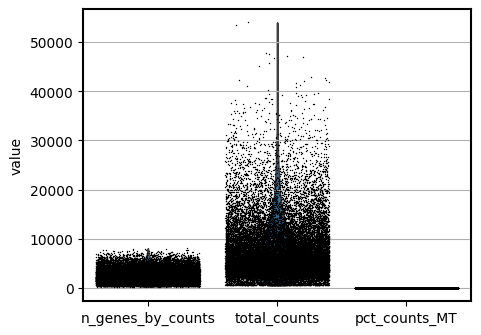

In [13]:
#Violin plots

#mock dataset
sc.pl.violin(
    adata_3dpi,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)

In [14]:
def plot_qc_metrics(adata):
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True)
    plt.show()

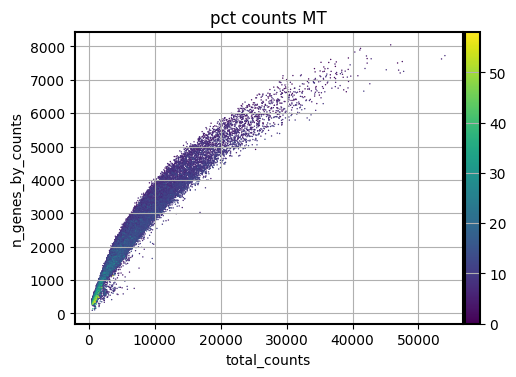

In [15]:
# Scatter plot of MT genes

#mock
sc.pl.scatter(adata_3dpi, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

In [16]:
# filter for percent mito
# We filter out cells with >10% mitochondrial content.
# This removes dying or stressed cells, which can skew infection-related gene expression.
adata_3dpi = adata_3dpi[adata_3dpi.obs['pct_counts_MT'] < 10, :]

Normalize and transform.

In [17]:
def normalize_and_scale(adata):
    """
    Normalize, log-transform, and scale gene expression data.
    """
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    print(f"✅ Normalized and scaled data with {adata.n_vars} HVGs.")
    return adata

In [18]:
# Normalize counts per cell to 10,000

#mock dataset
adata_3dpi.layers["counts"] = adata_3dpi.X.copy()
sc.pp.normalize_total(adata_3dpi)
sc.pp.log1p(adata_3dpi)  # log normalization

/tmp/ipython-input-3255618180.py:4: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_3dpi.layers["counts"] = adata_3dpi.X.copy()


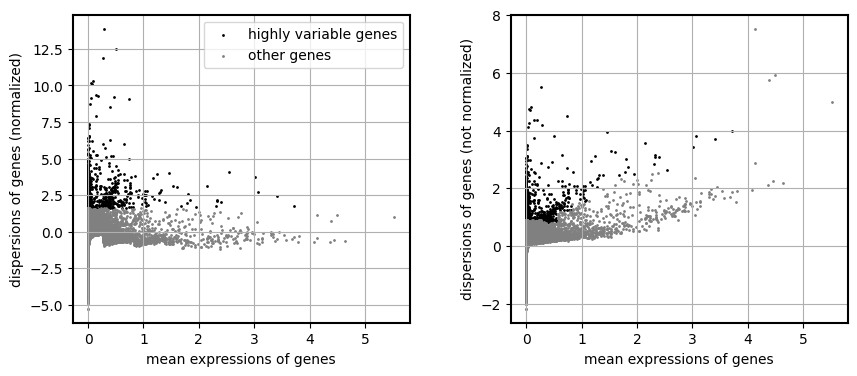

In [19]:
#feature selection
sc.pp.highly_variable_genes(adata_3dpi, n_top_genes=1000)
sc.pl.highly_variable_genes(adata_3dpi)

Dimensionality Reduction

PCA

In [20]:
def run_pca_umap(adata, n_pcs=40, n_neighbors=10):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    print("PCA and UMAP completed.")
    return adata

In [21]:
#Dim Reduction
sc.tl.pca(adata_3dpi)

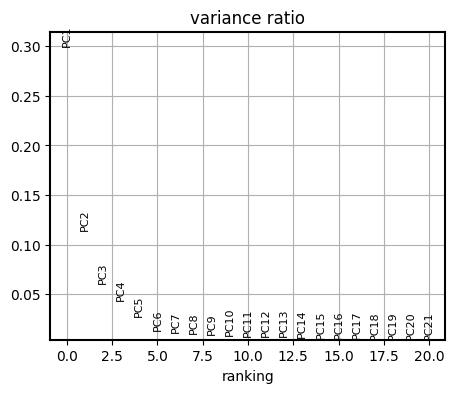

In [22]:
from leidenalg.Optimiser import log
sc.tl.pca(adata_3dpi, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_3dpi, n_pcs=20,log=False)

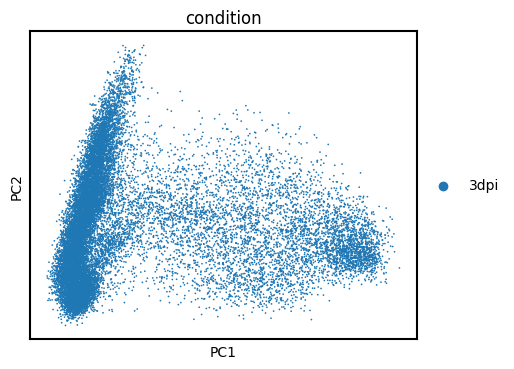

In [23]:
adata_3dpi.obs['condition'] = '3dpi'
sc.pl.pca(adata_3dpi, color="condition", cmap="coolwarm")

In [24]:
sc.pp.neighbors(adata_3dpi)
sc.tl.umap(adata_3dpi)

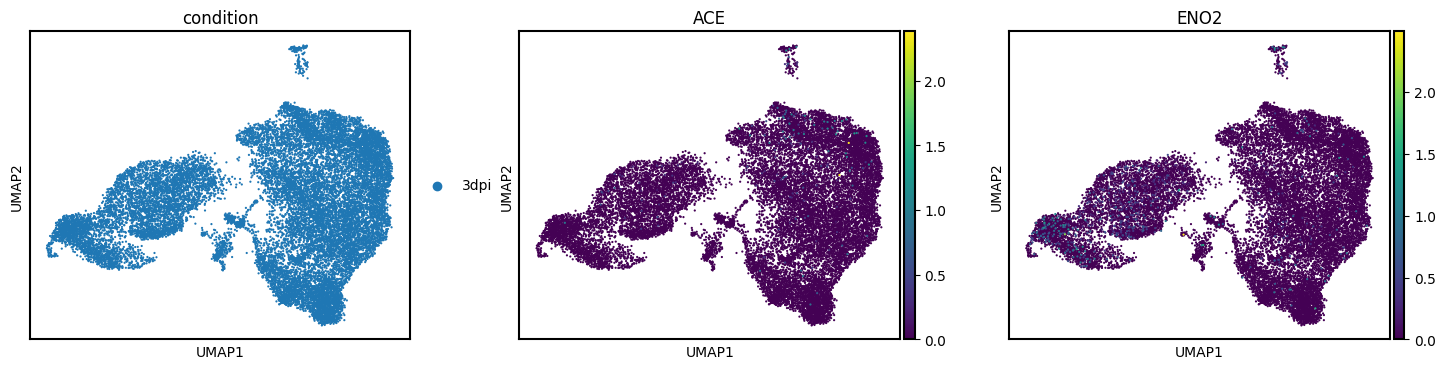

In [25]:
sc.pl.umap(
    adata_3dpi,
    color=["condition", 'ACE', 'ENO2'],
    size=10,
)

In [26]:
## Clustering by communities.

##Clustering by communities in single-cell RNA-seq is the process of grouping cells that show similar expression profiles — essentially, discovering putative cell types or states.

## Once PCA compresses your data into a manageable set of dimensions, clustering algorithms like Leiden operate on a graph-based representation of cell–cell relationships.

## Usually used for cell type detection

In [27]:
def run_clustering(adata, resolution=0.02):
    sc.tl.leiden(adata, resolution=resolution)
    print(f"Leiden clustering done. Found {adata.obs['leiden'].nunique()} clusters.")
    return adata

In [28]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata_3dpi, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.25 )

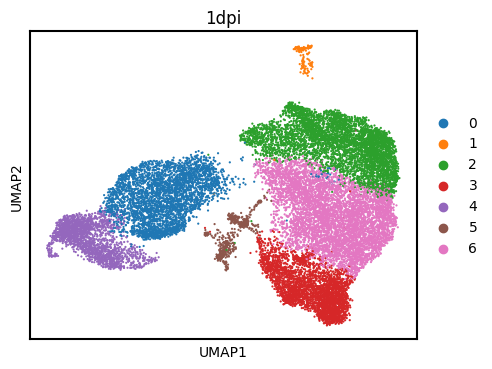

In [29]:
sc.pl.umap(
    adata_3dpi,
    color=["leiden_res_"],
    size=10,
    title= '1dpi'
)

Cell Annotation


In [30]:
# Import decoupler for automatic mapping
import decoupler as dc

In [31]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

In [32]:
markers.shape

(8211, 13)

In [33]:
markers['organ'].unique()

array(['Liver', 'Reproductive', 'Brain', 'Immune system', 'Zygote',
       'Kidney', 'Blood', 'Lungs', 'Bone', 'GI tract', nan, 'Vasculature',
       'Pancreas', 'Heart', 'Mammary gland', 'Olfactory system',
       'Connective tissue', 'Epithelium', 'Skeletal muscle', 'Skin',
       'Embryo', 'Smooth muscle', 'Eye', 'Adrenal glands', 'Thyroid',
       'Placenta', 'Thymus', 'Parathyroid glands', 'Oral cavity',
       'Urinary bladder'], dtype=object)

In [34]:
markers = markers[markers["organ"].isin(['Lungs', 'Epithelium', 'Immune system', 'Smooth Muscles'])]

In [35]:
markers.shape

(2099, 13)

In [36]:
import decoupler as dc
import pandas as pd

# 1. Re-load markers from the resource to ensure it's in the initial state
markers = dc.op.resource(name="PanglaoDB", organism="human")

# 2. Filter by organ
if 'organ' in markers.columns:
    markers = markers[markers["organ"].isin(['Lungs', 'Epithelium', 'Smooth muscle'])]
else:
    print("Warning: 'organ' column not found for organ filtering. Skipping.")

# 3. Remove duplicated entries using 'cell_type' and 'genesymbol'
# Check if columns exist before trying to use them for duplicated check
if 'cell_type' in markers.columns and 'genesymbol' in markers.columns:
    markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
else:
    print("Warning: 'cell_type' or 'genesymbol' column not found for duplicate removal. Skipping.")

# 4. Format because dc only accepts cell_type and genesymbol as 'source' and 'target'
# Check if columns exist before renaming
if 'cell_type' in markers.columns and 'genesymbol' in markers.columns:
    markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
else:
    print("Warning: 'cell_type' or 'genesymbol' column not found for renaming. Skipping.")

# 5. Select only 'source' and 'target' if they exist
if 'source' in markers.columns and 'target' in markers.columns:
    markers = markers[["source", "target"]]
else:
    print("Warning: 'source' or 'target' columns not found after processing. Final markers might be empty or incomplete.")

markers.head()

,source,target
,,
18,Pulmonary alveolar type II cells,ABCA3
31,Pulmonary alveolar type II cells,ABCD3
53,Basal cells,ACADVL
73,Mesothelial cells,ACKR3
75,Smooth muscle cells,ACKR3


In [37]:
adata_3dpi.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1', 'AC233755.2',
       'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C', 'scv2_orf1-10'],
      dtype='object', length=33539)

In [38]:
import decoupler as dc
#3dpi
dc.mt.ulm(data=adata_3dpi, net=markers, tmin=3)

In [39]:
#3dpi
score_3dpi = dc.pp.get_obsm(adata_3dpi, key="score_ulm")

In [40]:
#Rank genes

#3dpi
adata_3dpi_gene_rank = dc.tl.rankby_group(score_3dpi, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
adata_3dpi_gene_rank = adata_3dpi_gene_rank[adata_3dpi_gene_rank["stat"] > 0]
adata_3dpi_gene_rank.head(5)

,group,reference,name,stat,meanchange,pval,padj
0,0,rest,Ciliated cells,58.901416,2.746753,0.000000e+00,0.000000e+00
1,0,rest,Epithelial cells,33.712499,1.550632,4.020490e-230,3.216392e-229
2,0,rest,Clara cells,23.123527,1.585982,9.584642e-114,5.111809e-113
4,0,rest,Pulmonary alveolar type II cells,21.082228,0.485465,1.274427e-95,4.078167e-95
5,0,rest,Airway goblet cells,18.660253,1.162655,9.877775e-76,2.634073e-75


In [41]:
#3dpi
top_cell_type_per_group_mock = adata_3dpi_gene_rank.groupby('group')['name'].apply(lambda x: x.head(1))
display(top_cell_type_per_group_mock.to_dict())

/tmp/ipython-input-3126710757.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_cell_type_per_group_mock = adata_3dpi_gene_rank.groupby('group')['name'].apply(lambda x: x.head(1))


{('0', 0): 'Ciliated cells',
 ('1', 31): 'Alveolar macrophages',
 ('2', 32): 'Ionocytes',
 ('3', 48): 'Myoepithelial cells',
 ('4', 64): 'Ciliated cells',
 ('5', 90): 'Vascular smooth muscle cells',
 ('6', 96): 'Mesothelial cells'}

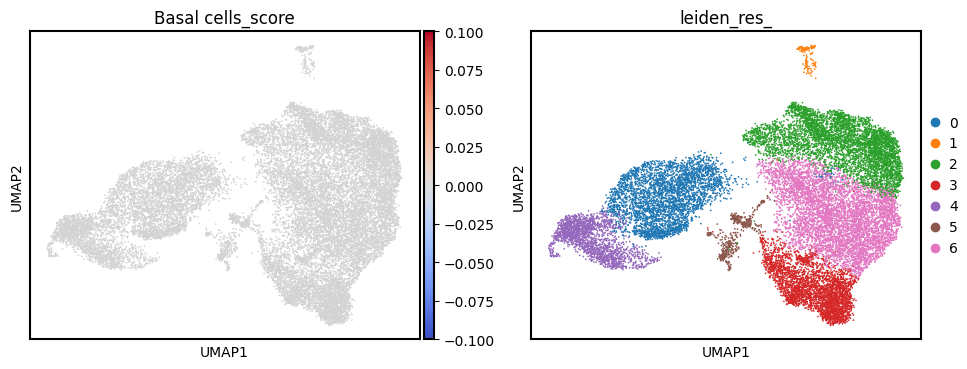

In [42]:
# To plot the 'Basal cells' scores on the UMAP of adata_3dpi, we need to extract this score from score_3dpi and add it to adata_3dpi.obs.
# The 'leiden_res0_02' key is incorrect; it should be 'leiden_res_'.

# Check if 'Basal cells' is a column in score_3dpi.var_names before trying to add it.
if 'Basal cells' in score_3dpi.var_names:
    adata_3dpi.obs['Basal cells_score'] = score_3dpi[:, 'Basal cells'].X.flatten()
    sc.pl.umap(adata_3dpi, color=["Basal cells_score", "leiden_res_"], cmap="coolwarm")
else:
    print("Warning: 'Basal cells' score not found in score_3dpi. Plotting only leiden_res_.")
    sc.pl.umap(adata_3dpi, color=["leiden_res_"], cmap="coolwarm")

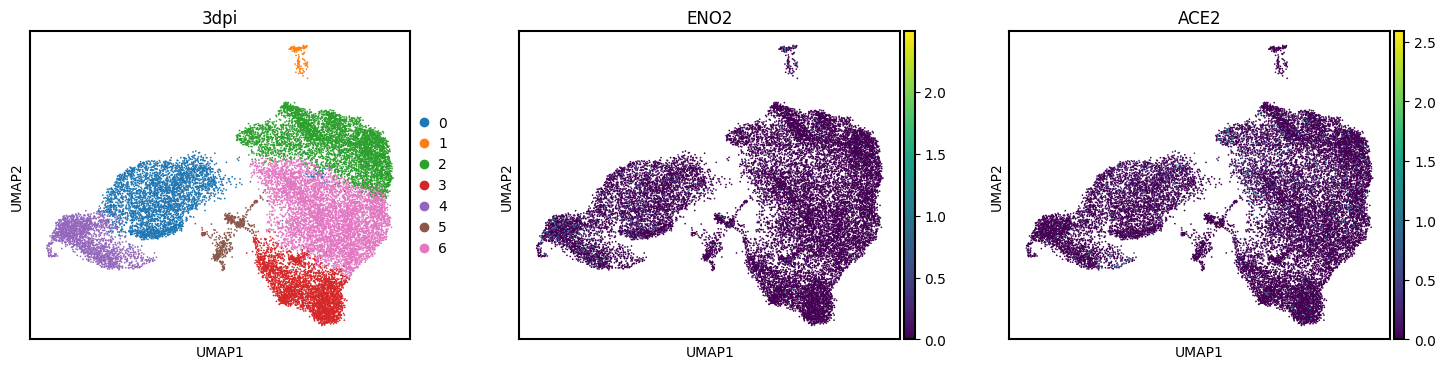

In [43]:
sc.pl.umap(
    adata_3dpi,
    color=[ "leiden_res_", 'ENO2', 'ACE2'],
    ncols=8,
    title= '3dpi'
)

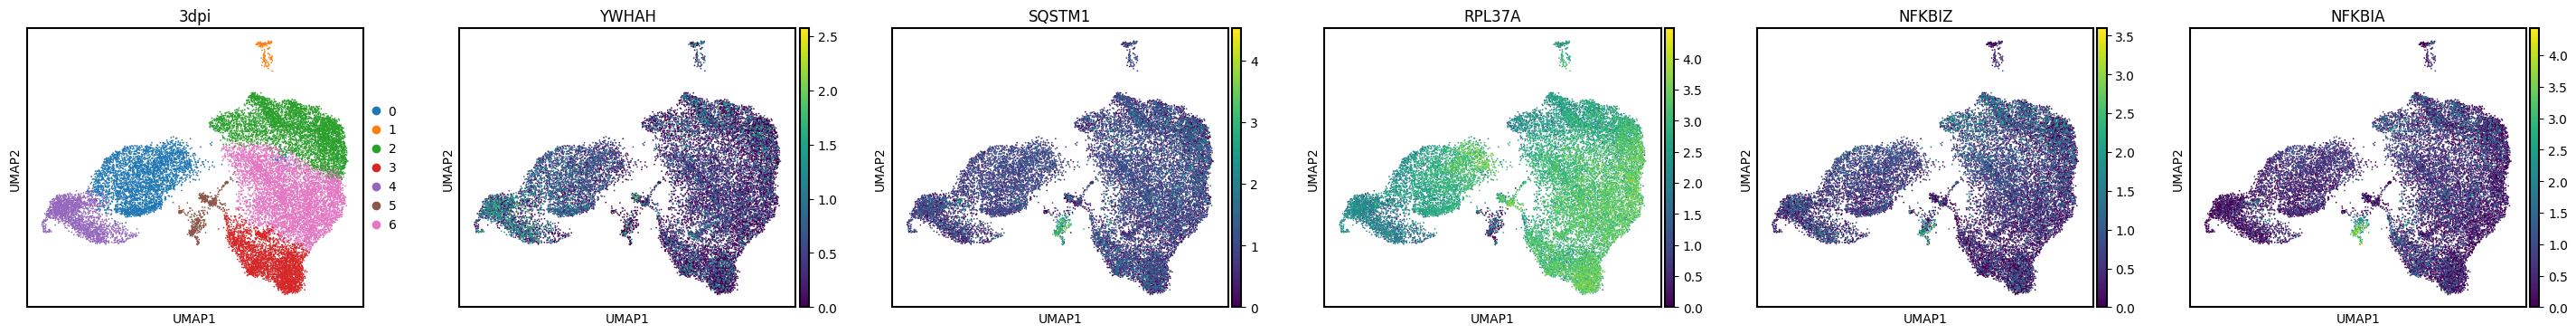

In [44]:
sc.pl.umap(
    adata_3dpi,
    color=[ "leiden_res_", 'YWHAH', 'SQSTM1', 'RPL37A', 'NFKBIZ', 'NFKBIA'],
    ncols=8,
    title= '3dpi'
)

In [45]:
#3dpi
dict_ann_3dpi_raw = adata_3dpi_gene_rank[adata_3dpi_gene_rank["stat"] > 0].groupby("group").head().set_index("group")["name"].to_dict()
dict_ann_3dpi = {k: f"{v} ({k})" for k, v in dict_ann_3dpi_raw.items()}
display(dict_ann_3dpi)

/tmp/ipython-input-1737897269.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_ann_3dpi_raw = adata_3dpi_gene_rank[adata_3dpi_gene_rank["stat"] > 0].groupby("group").head().set_index("group")["name"].to_dict()


{'0': 'Airway goblet cells (0)',
 '1': 'Alveolar macrophages (1)',
 '2': 'Pulmonary alveolar type II cells (2)',
 '3': 'Smooth muscle cells (3)',
 '4': 'Vascular smooth muscle cells (4)',
 '5': 'Smooth muscle cells (5)',
 '6': 'Epithelial cells (6)'}

In [46]:
#3dpi
adata_3dpi.obs["leiden_res_"] = adata_3dpi.obs["leiden_res_"][:].astype('category').cat.rename_categories(dict_ann_3dpi)

In [47]:
print("Performing differential expression analysis for adata_3dpi...")
sc.tl.rank_genes_groups(adata_3dpi, groupby='leiden_res_', method='wilcoxon', rankby_abs=True, key_added='rank_genes_groups_1dpi')

Performing differential expression analysis for adata_3dpi...


In [48]:
data_combined = ad.concat([adata_3dpi])

# Create a combined 'condition_cell_type' column for dot plot grouping
data_combined.obs['condition_cell_type'] = data_combined.obs['condition'].astype(str) + '_' + data_combined.obs['leiden_res_'].astype(str)

print("Combined AnnData object created and 'condition_cell_type' column added.")
print(data_combined.obs['condition_cell_type'].value_counts().head())

Combined AnnData object created and 'condition_cell_type' column added.
condition_cell_type
3dpi_Epithelial cells (6)                    5608
3dpi_Pulmonary alveolar type II cells (2)    4823
3dpi_Airway goblet cells (0)                 3517
3dpi_Smooth muscle cells (3)                 3221
3dpi_Vascular smooth muscle cells (4)        1948
Name: count, dtype: int64


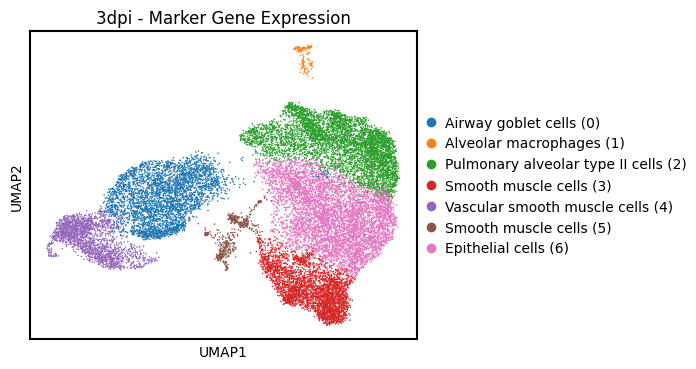

In [49]:
#Visualisation of cell annotation
# Leiden clustering identifies transcriptionally similar cell groups.
# This helps distinguish infected vs. bystander cell populations across infection stages.
#1dpi
sc.pl.umap(
    adata_3dpi,
    color=["leiden_res_"],
    ncols=3,
    title='3dpi - Marker Gene Expression',
    size=5
)

In [50]:
data_combined.obs['condition'].value_counts()

,count
condition,
3dpi,19746


/tmp/ipython-input-3146228492.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


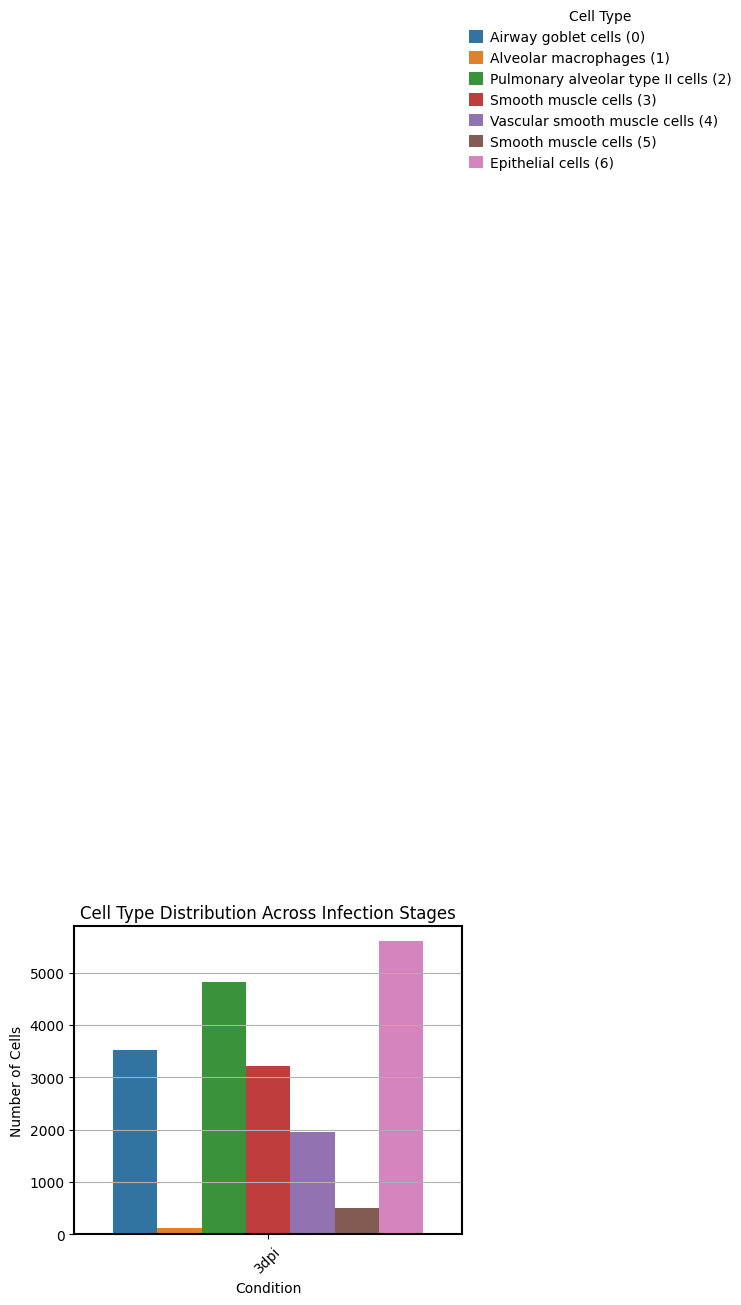

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cell type frequency per condition
# Use 'leiden_res_' column which contains the annotated cell types
cell_counts = data_combined.obs.groupby(['condition', 'leiden_res_'], observed=True).size().reset_index(name='count')

sns.barplot(data=cell_counts, x='condition', y='count', hue='leiden_res_')
plt.title("Cell Type Distribution Across Infection Stages")
plt.ylabel("Number of Cells")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1,4), loc='upper left')
plt.tight_layout()
plt.show()

Trajectory Inference It is an attempt to understand how cells transition from one type to another (like stem → mature)?

In [52]:
#Trajectory analysis
sc.tl.draw_graph(adata_3dpi)

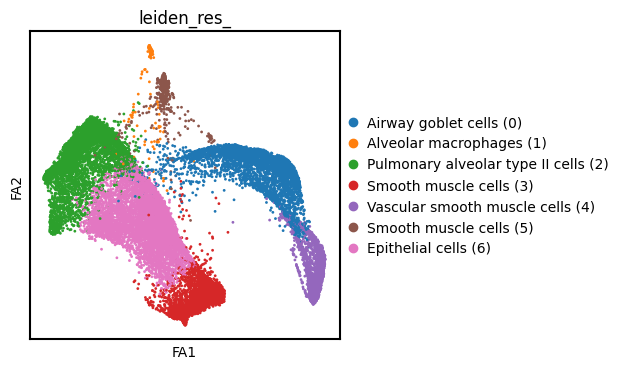

In [53]:
# 3dpi
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.draw_graph(adata_3dpi, color='leiden_res_', size = 16)

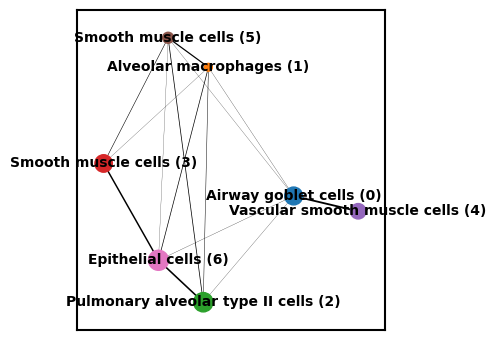

In [54]:
#PAGA 3dpi

sc.tl.paga(adata_3dpi, groups='leiden_res_')

sc.pl.paga(adata_3dpi, color=['leiden_res_'])

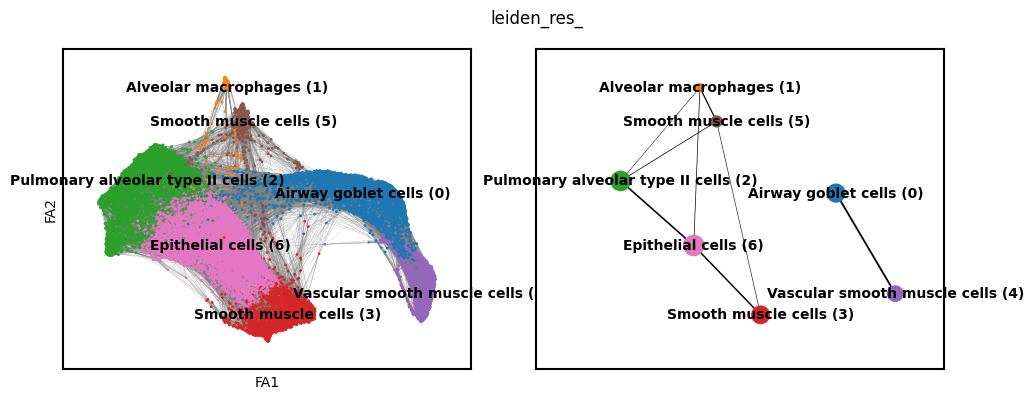

[<Axes: xlabel='FA1', ylabel='FA2'>, <Axes: >]

In [55]:
#3dpi
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.paga_compare(adata_3dpi, threshold=0.03, frameon=True, edges=True, size = 16)

In [57]:
# Calculate diffusion pseudotime (DPT)

# 3dpi
# As an example, let's select a cell from the first cluster (cluster '0') as the root.
# You might need to adjust this based on your biological knowledge.
root_cluster_3dpi = 'Myofibroblasts (0)' # Corrected to an existing annotated cluster name
if root_cluster_3dpi in adata_3dpi.obs['leiden_res_'].cat.categories:
    root_cell_idx_3dpi = adata_3dpi.obs['leiden_res_'] == root_cluster_1dpi
    if np.any(root_cell_idx_3dpi):
        adata_3dpi.uns['iroot'] = np.flatnonzero(root_cell_idx_3dpi)[0] # Set iroot
        sc.tl.dpt(adata_3dpi) # Call dpt without the 'root' argument
        # Now plot with dpt_pseudotime if it was calculated
        sc.pl.draw_graph(adata_3dpi, color=['dpt_pseudotime', 'leiden_res_'], legend_loc='on data', size = 24)
    else:
        print(f"Warning: No cells found in cluster {root_cluster_3dpi} for adata_3dpi. Skipping DPT calculation and plotting.")
else:
    print(f"Warning: Cluster {root_cluster_3dpi} not found in adata_3dpi categories. Skipping DPT calculation and plotting.")

In [ ]:
import numpy as np
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

# Compare ACE2 expression across conditions
ace2_means = [adata_3dpi[:, 'ACE2'].X.mean()]

# Bootstrapped confidence intervals
boot_samples = 1000
ci_low, ci_high = np.percentile(
    [np.mean(np.random.choice(ace2_means, size=len(ace2_means), replace=True))
     for _ in range(boot_samples)],
    [2.5, 97.5]
)

print(f"95% CI for ACE2 mean expression: [{ci_low:.4f}, {ci_high:.4f}]")

95% CI for ACE2 mean expression: [0.0286, 0.0286]


<Axes: >

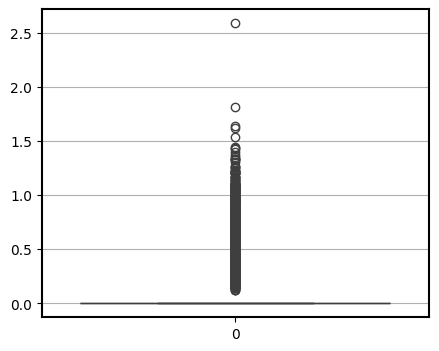

In [ ]:
sns.boxplot(data=[adata_3dpi[:, 'ACE2'].X.toarray().flatten()])

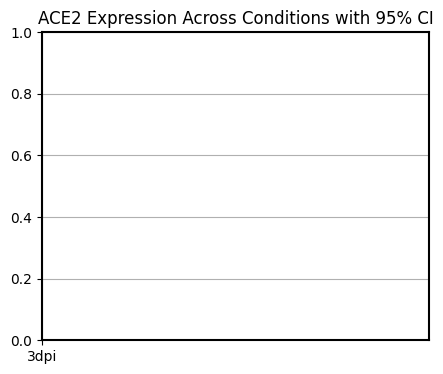

In [ ]:
plt.xticks([0], ['3dpi'])
plt.title("ACE2 Expression Across Conditions with 95% CI")
plt.show()